In the previous chapter I have created a deep learning network with a flaten layer, a dense layer and an output layer. We achieved about 87 percent accuracy on the test set. In this chapter, I will introduce the concept of convolutions and pooling that are very common in deep learning when working with images.

# Convolution layer

The convolutional layer's in tensorflow official documentation can be found here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D/.

Convolution is a simple mathematical operation which is fundamental to many common image processing operators. Convolution provides a way of 'multiplying together' two arrays of numbers, generally of different sizes, but of the same dimensionality, to produce a third array of numbers of the same dimensionality. This can be used in image processing to implement operators whose output pixel values are simple linear combinations of certain input pixel values.

The following animation gives a good understanding of the convolution operation: 

![convolution](pictures/convolution.gif)

The block on the left represents an image with certain pixel values and the small 3x3 block in the middle is often called as the **filter**. 

The final values are calculated by a simple formula - the filter is beeing slided across the image and values in the filer are multiplied by the appropriate pixel values and summed up. For example, the first value in the resulting block is calculated by the formula: 

7 * 1 + 0 * 2 + -1 * 3 + 1 * 4 + 5 * 0 + 3 * -1 + 3 * 1 + 3 * 0 + 2 * -1 = 6


Different filters highlight different properties in images. Some filters put emphasis on horizontal lines, others to vertical lines and anything in between. Let us load the ascent image from the scipy library showing people climbing up a set of stairs. The image is 512x512 pixel dimensions.

In [1]:
import cv2
import numpy as np
from scipy import misc
i = misc.ascent()
print(i.shape)

(512, 512)


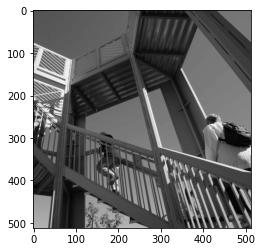

In [2]:
import matplotlib.pyplot as plt
plt.grid(False)
plt.gray()
plt.imshow(i)
plt.show()

The image is stored as a numpy array, so we can create the transformed image by just copying that array. Let's also get the dimensions of the image so we can loop over it later.

In [3]:
i_transformed = np.copy(i)
size_x = i_transformed.shape[0]
size_y = i_transformed.shape[1]

Let us create a well known simple filter for edge detection:
    
$$\begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0
\end{bmatrix}_{3x3}$$	

In [4]:
# Filter for edge detection
filter = [[0, 1, 0], [1, -4, 1], [0, 1, 0]]

In [5]:
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0
      convolution = convolution + (i[x - 1, y-1] * filter[0][0])
      convolution = convolution + (i[x, y-1] * filter[0][1])
      convolution = convolution + (i[x + 1, y-1] * filter[0][2])
      convolution = convolution + (i[x-1, y] * filter[1][0])
      convolution = convolution + (i[x, y] * filter[1][1])
      convolution = convolution + (i[x+1, y] * filter[1][2])
      convolution = convolution + (i[x-1, y+1] * filter[2][0])
      convolution = convolution + (i[x, y+1] * filter[2][1])
      convolution = convolution + (i[x+1, y+1] * filter[2][2])
      if(convolution<0):
        convolution=0
      if(convolution>255):
        convolution=255
      i_transformed[x, y] = convolution

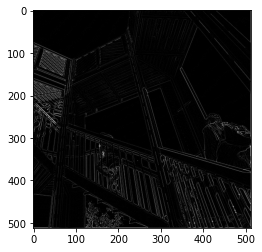

In [6]:
plt.grid(False)
plt.gray()
plt.imshow(i_transformed)
plt.show()

In practise, the tensorflow layer creates random filters of fixed size and then during the training phase the algorithm decides how to change the filter values to optimize the loss function as best as possible. 

# Pooling

After obtaining our convolved features as described in the previous section, we decide the size of the region, say $mxn$ to pool our convolved features over. Then, we divide our convolved features into disjoint $mxn$ regions, and take the mean (or maximum) feature activation over these regions to obtain the pooled convolved features. These pooled features can then be used for classification.

This technique is usefull because, at least to some degree, it negates the effect of small pixel changes in images. For example, a bird's head could be in the middle of the image or slightly to left or to the right. 

A visual for the max pooling:

![maxpooling](pictures/maxpooling.gif)

Official documentation in tensorflow: https://www.tensorflow.org/api_docs/python/tf/nn/pool

# Putting everything together

In [7]:
import tensorflow as tf

# Initiating the class
mnist = tf.keras.datasets.fashion_mnist

# Downloading the data
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# Preprocesing the images
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

# Adding the conv layer and max pooling layer
model = tf.keras.models.Sequential([
    # Convolutional layers can be used as input layers
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    
    # Max pooling layer
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1384576   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,386,506
Trainable params: 1,386,506
Non-trainable params: 0
_________________________________________________________________


You may notice that the output shape of the first convolutional layer is 26 x 26 x 64 while the original shape of the pictures are 28 x 28. The loss of pixels is due to the nature of filtering. Recall the animation in the first section. The pixels that are on the edge of the picture are used just for the calculations of filter values and the droped. 

The max pooling layer output is shaped 13 x 13 x 64 and this is because we are using a (2, 2) square which reduces the original picture size to a quarter of the original (recall the animation). The flattened layer output size can be caluclated by the formula 13*13*64.

The number 64 is equal to the number of filters defined in the tf.keras.layers.Conv2D layer. This means that there were 64 unique filters created. and thus, in the heart of the network, from every input picture there were 64 new ones created. 

In [8]:
# Fitting the model
model.fit(training_images, training_labels, epochs=5)

# Evaluating accuracy
test_loss = model.evaluate(test_images, test_labels, verbose=False)
print(test_loss[1])

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 24s 406us/sample - loss: 0.4127 - accuracy: 0.8556
Epoch 2/5
60000/60000 [==============================] - 24s 398us/sample - loss: 0.2802 - accuracy: 0.8996
Epoch 3/5
60000/60000 [==============================] - 24s 407us/sample - loss: 0.2324 - accuracy: 0.9158
Epoch 4/5
60000/60000 [==============================] - 24s 408us/sample - loss: 0.1976 - accuracy: 0.9270
Epoch 5/5
60000/60000 [==============================] - 25s 409us/sample - loss: 0.1672 - accuracy: 0.9384
0.9012


The training accuracy is now around 95 percent and the test set accuracy is around 91 percent. Remember, without the convolutional and maxpooling layers, the accuracy for training was around 86 percent and the test set accuracy was around 85 percent. In both cases, adding the two layers to our previous image recognition model imporved the results quite substantialy. 